In [1]:
%load_ext autoreload
%autoreload 2


from sklearn.linear_model import LogisticRegression, LinearRegression

import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from logistic_regression import logistic
from scipy.stats.mstats import mquantiles
import seaborn as sns
from typing import List
from functools import reduce
import operator
import scipy.stats
from plot_utils import PlotInfo, save_freq_acc_plot_and_get_info, save_logistic_regression_lines_plot_for_shots, save_logistic_regression_lines_plot_for_models, save_logistic_regression_lines_plot_for_models_shots, save_lines_plot_for_models_shots, get_farthest_points, FrequencyCache
import plot_utils

In [7]:
 #  RUN ONCE
my_frequency_cache = FrequencyCache()

In [97]:
# RUN EVERYTIME
mpl.rcdefaults()
sns.set_theme(style="white")
plot_utils.frequency_cache_singleton = my_frequency_cache

In [10]:
def my_default_index_score(list_i: List[int], list_j: List[int]) -> float:
    scores = [0.01 if i == j else abs(i-j) for (i, j) in zip(list_i, list_j)]
    return reduce(operator.mul, scores)**2

def my_default_index_filter(list_i: List[int]):
    return not any((len(str(i)) < 2 or i % 10 == 0) for i in list_i)



In [11]:
top_points = get_farthest_points('mult', 4, 'gptj', 'xy', index_score=my_default_index_score, index_filter=my_default_index_filter)
for x in top_points[:100]:
    print("\t".join("%.2f" % a if isinstance(a, float) else str(a) for a in x[1:]))

I'm at index 9999999, lines: (('274087', '300671'), 1)

Size: 3775
('12', '13')	('13', '13')	0.43	1.00	0.40
('11', '11')	('11', '12')	0.29	0.40	1.00
('11', '12')	('11', '13')	0.26	1.00	0.30
('13', '14')	('14', '14')	0.35	0.70	0.20
('24', '47')	('24', '48')	1.19	0.00	0.80
('24', '48')	('24', '49')	1.18	0.80	0.00
('23', '48')	('24', '48')	1.17	0.00	0.80
('13', '13')	('13', '14')	0.37	0.40	0.70
('11', '13')	('12', '13')	0.19	0.30	1.00
('24', '48')	('25', '48')	1.06	0.80	0.30
('11', '12')	('11', '19')	0.82	1.00	0.00
('11', '24')	('12', '24')	0.55	0.20	0.80
('14', '14')	('14', '15')	0.33	0.20	0.40
('17', '18')	('17', '19')	0.25	0.80	0.00
('12', '13')	('12', '16')	0.33	1.00	0.10
('11', '12')	('11', '15')	0.45	1.00	0.70
('15', '16')	('15', '17')	0.23	1.00	0.60
('24', '46')	('24', '48')	1.14	0.00	0.80
('22', '48')	('24', '48')	1.13	0.00	0.80
('24', '48')	('26', '48')	1.18	0.80	0.10
('12', '23')	('12', '24')	0.50	0.40	0.80
('11', '12')	('11', '17')	0.72	1.00	0.70
('13', '14')	('13', '19')	0.70	

I'm at index 9999999, lines: (('274087', '300671'), 1)



KeyboardInterrupt: 

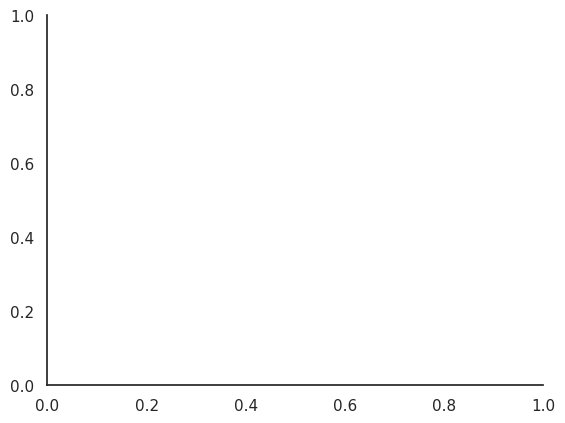

In [178]:
fig, ax = plt.subplots(1, 1)
sns.despine()
a = save_freq_acc_plot_and_get_info('mult', 4, 'gptj', key='xy', show_plot = True,
                                    important_points=[
                                                      # "('24', '47')",
                                                      "('24', '48')",
                                                      # "('23', '47')",
                                                      "('23', '48')",
                                                      ],
                                    plot_scatters=False,
                                    plot_log_reg=False)

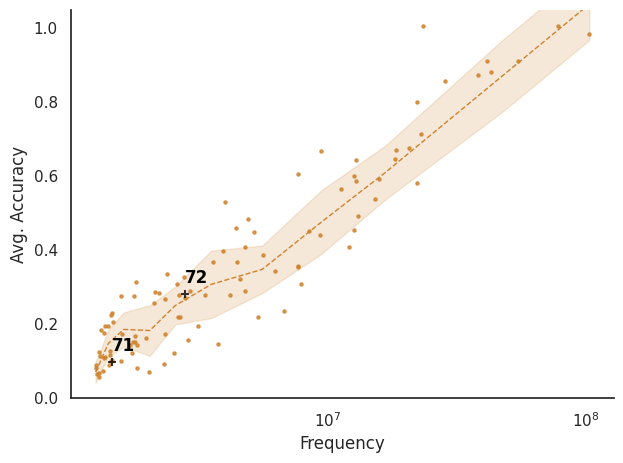

In [179]:
a = save_freq_acc_plot_and_get_info(
    'mult', 2, 'gptj', key='x', show_plot = True,
    important_points=[72, 71],
    plot_log_reg=False,
    plot_bar=False)

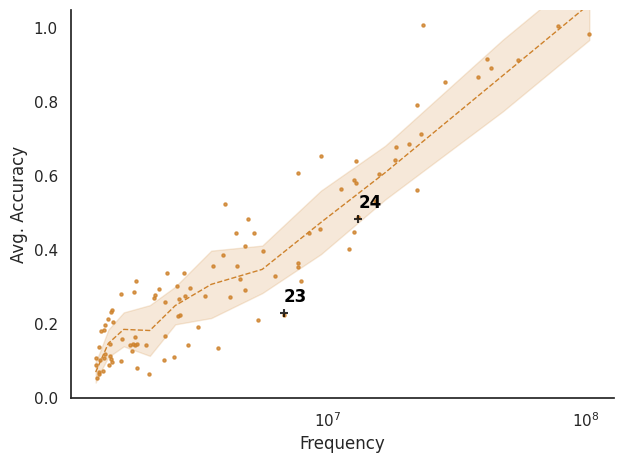

In [105]:
a = save_freq_acc_plot_and_get_info(
    'mult', 2, 'gptj', key='x',
    plot_log_reg=False,
    show_plot=True,
    plot_bar=False,
    important_points=[23, 24])

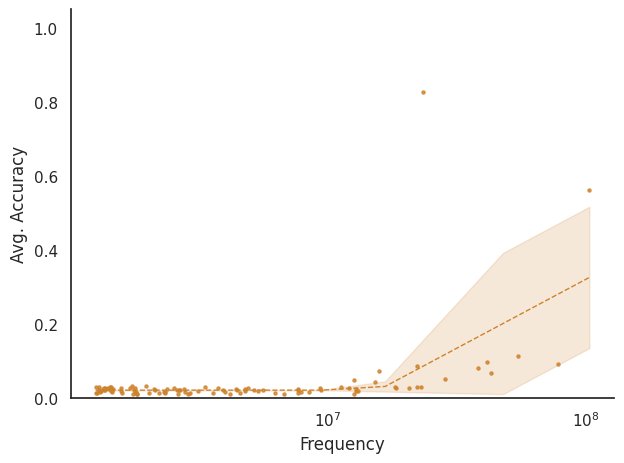

0 : 0.05431372549019608


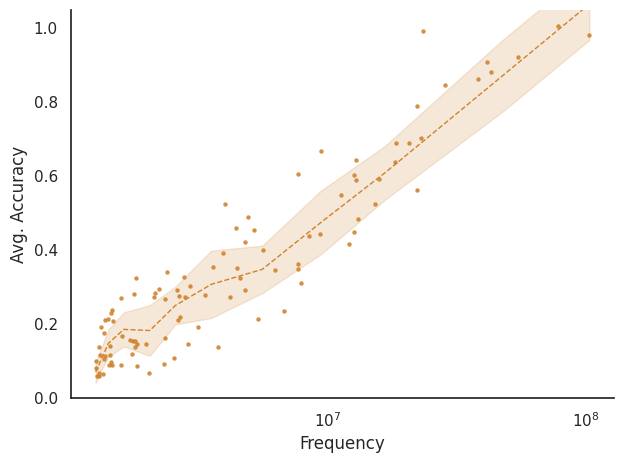

2 : 0.35939584150647313


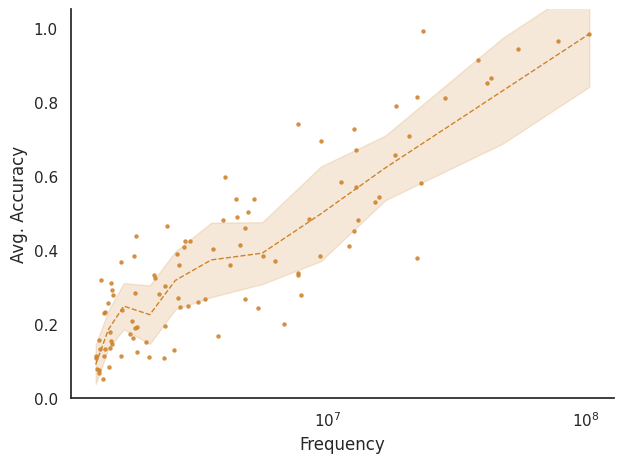

4 : 0.39218995290423864


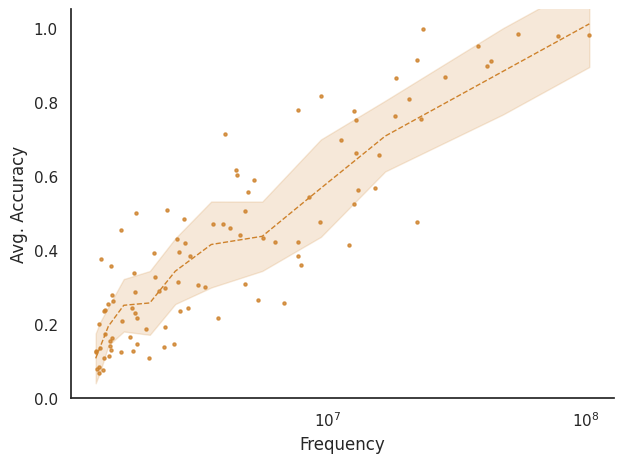

8 : 0.4293008641005499


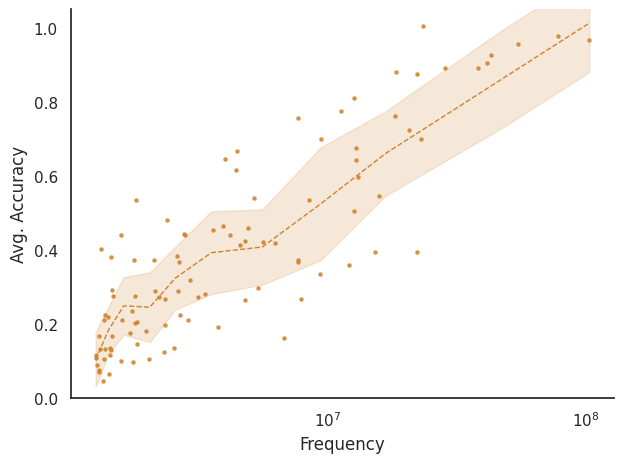

16 : 0.4088512981904013


In [104]:
WORD = 'mult'
MODEL = 'gptj'
for shots in [0, 2, 4 ,8, 16]:
    fig, ax = plt.subplots(1, 1)
    sns.despine()
    a = save_freq_acc_plot_and_get_info(
        WORD, shots, MODEL, key='x',
        plot_log_reg=False,
        plot_bar=False,
        show_plot = True)
    print(shots, ":", a.accuracy_all)


Total Not Found for key xz is 230


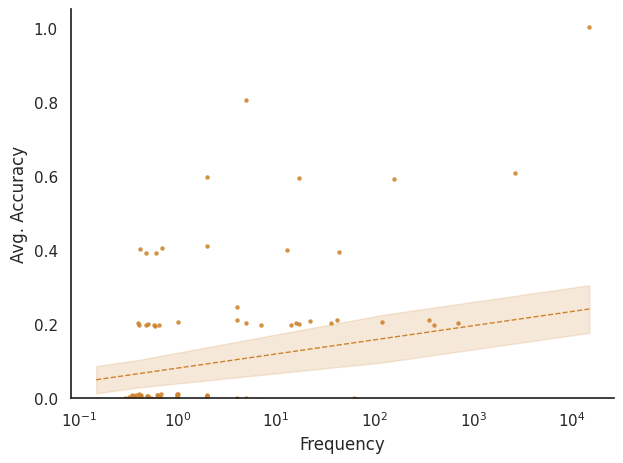

In [182]:
q = save_freq_acc_plot_and_get_info(
    'day', 2, 'gptj', key='xz',
    plot_log_reg=False,
    plot_bar=False,
    show_plot=True,
    quantile_number=2)

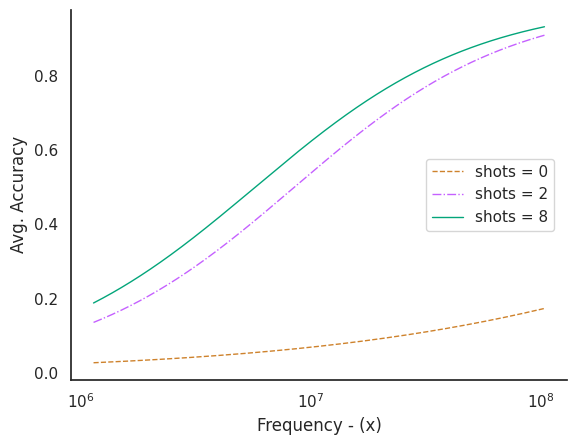

In [184]:
save_logistic_regression_lines_plot_for_shots(
    'mult', 'gptj', shots=[0, 2, 8], key='x', show_plot=True)

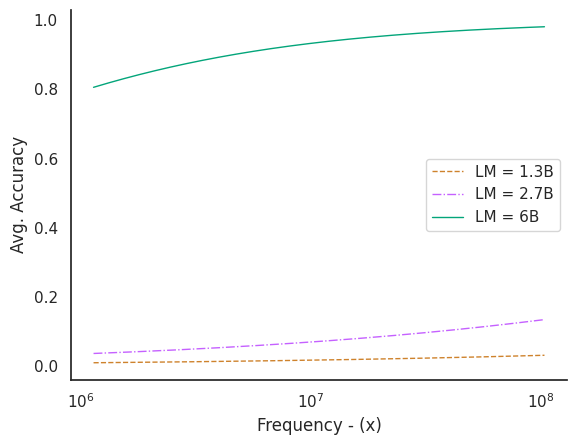

In [185]:
save_logistic_regression_lines_plot_for_models(
    'plus', ['gptjsmall', 'gptjlarge', 'gptj'], shot=2, key='x',
    show_plot=True)

## For Latex Results

In [ ]:

def create_arithmetics_similarity_1():
    arithmetics_task_1_path = './latex_results/arithmetics-gptj.csv'
    template_header = "\\multirow{{{0}}}{{*}}{{{1}}} & {2} & {3:.2f} & {4:.2f} & {5:.2f}\\\\\n"
    template_row = "& {0} & {1:.2f} & {2:.2f} & {3:.2f}\\\\\n"
    footer = "\midrule\n"
    result = {
        'Task': [],
        'Model': [],
        '#Shot': [],
        'Accuracy': [],
        'Similarity_x': [],
        'Similarity_xy': [],
        'Similarity_xz': [],
    }
    latex_content = ""
    for (task, word) in [('Multiplication', 'mult'), ('Addition', 'plus')]:
        task_result = []
        for model in ['gptj']:
            for shot in [0, 2, 4, 8, 20]:
                result['Task'].append(task)
                result['Model'].append(model)
                result['#Shot'].append(shot)
                plot_info_x = PlotInfo(word, shot, model, key_type='x') \
                    .quantile_accuracies_plot(q_num=10) \
                    .calculate_accuracy_all()
                result['Accuracy'].append(plot_info_x.accuracy_all)
                result['Similarity_x'].append(plot_info_x.similarity)
                result['Similarity_xy'].append(
                    PlotInfo(word, shot, model, key_type='xy').quantile_accuracies_plot(q_num=10).similarity)
                result['Similarity_xz'].append(
                    PlotInfo(word, shot, model, key_type='xz').quantile_accuracies_plot(q_num=10).similarity)
                task_result.append([result['#Shot'][-1], result['Accuracy'][-1], result['Similarity_x'][-1], result['Similarity_xy'][-1]])
        latex_content += template_header.format(len(task_result), task, task_result[0][0], task_result[0][1], task_result[0][2], task_result[0][3])
        for tt in task_result[1:]:
            latex_content += template_row.format(*tt)
        latex_content += footer
    pd.DataFrame(result).to_csv(arithmetics_task_1_path)
    print(latex_content)


create_arithmetics_similarity_1()




In [ ]:

def create_comparison_similarity_1():
    comparison_task_1_path = './latex_results/comparison-gptj.csv'
    template_header = "\\multirow{{{0}}}{{*}}{{{1}}} & {2} & {3:.2f} & {4:.2f} & {5:.2f}\\\\\n"
    template_row = "& {0} & {1:.2f} & {2:.2f} & {3:.2f}\\\\\n"
    footer = "\midrule\n"
    result = {
        'Task': [],
        'Model': [],
        '#Shot': [],
        'Accuracy': [],
        'Similarity_x': [],
        'Similarity_xy': [],
        'Similarity_xz': [],
    }
    latex_content = ""
    for (task, word) in [('Min', 'compareless'), ('Max', 'comparemore')]:
        task_result = []
        for model in ['gptj']:
            for shot in [0, 2, 4, 8, 20]:
                result['Task'].append(task)
                result['Model'].append(model)
                result['#Shot'].append(shot)
                plot_info_x = PlotInfo(word, shot, model, key_type='x') \
                    .quantile_accuracies_plot(q_num=10) \
                    .calculate_accuracy_all()
                result['Accuracy'].append(plot_info_x.accuracy_all)
                result['Similarity_x'].append(plot_info_x.similarity)
                result['Similarity_xy'].append(
                    PlotInfo(word, shot, model, key_type='xy').quantile_accuracies_plot(q_num=10).similarity)
                result['Similarity_xz'].append(
                    PlotInfo(word, shot, model, key_type='xz').quantile_accuracies_plot(q_num=10).similarity)
                task_result.append([result['#Shot'][-1], result['Accuracy'][-1], result['Similarity_x'][-1], result['Similarity_xy'][-1]])
        latex_content += template_header.format(len(task_result), task, task_result[0][0], task_result[0][1], task_result[0][2], task_result[0][3])
        for tt in task_result[1:]:
            latex_content += template_row.format(*tt)
        latex_content += footer
    pd.DataFrame(result).to_csv(comparison_task_1_path)
    print(latex_content)


create_comparison_similarity_1()

In [ ]:
def create_timeunits_similarity_1():
    timeunits_task_1_path = './latex_results/timeunits-gptj.csv'
    template_header = "\\multirow{{{0}}}{{*}}{{{1}}} & {2} & {3:.2f} & {4:.2f} & {5:.2f}\\\\\n"
    template_row = "& {0} & {1:.2f} & {2:.2f} & {3:.2f}\\\\\n"
    footer = "\midrule\n"
    result = {
        'Task': [],
        'Model': [],
        '#Shot': [],
        'Accuracy': [],
        'Similarity_x': [],
        'Similarity_xy': [],
        # 'Similarity_xz': [],
    }
    latex_content = ""
    for (task, word) in [('Min2Sec', 'minute'), ('Hour2Min', 'hour'), ('Day2Hour', 'day'), ('Month2Week', 'month'), ('Year2Month', 'year'), ('Decade2Year', 'decade')]:
        task_result = []
        for model in ['gptj']:
            for shot in [2, 4, 8]:
                result['Task'].append(task)
                result['Model'].append(model)
                result['#Shot'].append(shot)
                plot_info_x = PlotInfo(word, shot, model, key_type='x') \
                    .quantile_accuracies_plot(q_num=10) \
                    .calculate_accuracy_all()
                result['Accuracy'].append(plot_info_x.accuracy_all)
                result['Similarity_x'].append(plot_info_x.similarity)
                result['Similarity_xy'].append(
                    PlotInfo(word, shot, model, key_type='xy').quantile_accuracies_plot(q_num=10).similarity)
                # result['Similarity_xz'].append(
                #     PlotInfo(word, shot, model, key_type='xz').quantile_accuracies_plot(q_num=10).similarity)
                task_result.append([result['#Shot'][-1], result['Accuracy'][-1], result['Similarity_x'][-1], result['Similarity_xy'][-1]])
        latex_content += template_header.format(len(task_result), task, task_result[0][0], task_result[0][1], task_result[0][2], task_result[0][3])
        for tt in task_result[1:]:
            latex_content += template_row.format(*tt)
        latex_content += footer
    pd.DataFrame(result).to_csv(timeunits_task_1_path)
    with open(timeunits_task_1_path+".txt", "w") as f:
        f.write(latex_content)
    print(latex_content)


create_timeunits_similarity_1()

In [ ]:
def create_generic_similarity_2(name: str, list_of_tasks, shots):
    generic_task_1_path = f'./latex_results/{name}-gptj-2.csv'
    template_header = "\\multirow{{{0}}}{{*}}{{{1}}} & {2} & {3:.2f} & {4:.2f} & {5:.2f}& {6:.2f} & {7:.2f}\\\\\n"
    template_row = "& {0} & {1:.2f} & {2:.2f} & {3:.2f}& {4:.2f} & {5:.2f}\\\\\n"
    footer = "\midrule\n"
    csv_rows = {
        'Task': [],
        'Model': [],
        '#Shot': [],
        'Accuracy': [],
        'Q0_Acc_x': [],
        'Q-1_Acc_x': [],
        'Q0_Acc_xy': [],
        'Q-1_Acc_xy': [],
        'Q0_Acc_xz': [],
        'Q-1_Acc_xz': [],
        'Similarity_x': [],
        'Similarity_xy': [],
        'Similarity_xz': [],
    }
    latex_content = ""
    q_num = 10
    for (task, word) in list_of_tasks:
        latex_result_multirow = []
        for model in ['gptj']:
            for shot in shots:
                csv_rows['Task'].append(task)
                csv_rows['Model'].append(model)
                csv_rows['#Shot'].append(shot)
                for key_type in ['x', 'xy', 'xz']:
                    plot_info = PlotInfo(word, shot, model, key_type=key_type) \
                        .quantile_accuracies_plot(q_num=q_num) \
                        .calculate_accuracy_all()
                    if key_type == 'x':
                        csv_rows['Accuracy'].append(plot_info.accuracy_all)
                    csv_rows[f'Q0_Acc_{key_type}'].append(plot_info.quantile_bins['accuracies'][0])
                    csv_rows[f'Q-1_Acc_{key_type}'].append(plot_info.quantile_bins['accuracies'][-1])
                    csv_rows[f'Similarity_{key_type}'].append(plot_info.similarity)
                latex_result_multirow.append([csv_rows['#Shot'][-1], csv_rows['Accuracy'][-1], csv_rows['Similarity_x'][-1], csv_rows['Similarity_xy'][-1],csv_rows['Similarity_x'][-1]/csv_rows['Accuracy'][-1], csv_rows['Similarity_xy'][-1]/csv_rows['Accuracy'][-1]])
        latex_content += template_header.format(len(latex_result_multirow), task, *latex_result_multirow[0])
        for tt in latex_result_multirow[1:]:
            latex_content += template_row.format(*tt)
        latex_content += footer
    pd.DataFrame(csv_rows).to_csv(generic_task_1_path)
    with open(generic_task_1_path+".txt", "w") as f:
        f.write(latex_content)
    print(latex_content)


create_generic_similarity_2("arithmetics", [('Multiplication', 'mult'), ('Addition', 'plus')], [0, 2, 4, 8, 16])
# create_generic_similarity_2("comparison", [('Min', 'compareless'), ('Max', 'comparemore')], [0, 2, 4, 8, 20])
create_generic_similarity_2("timeunits", [('Min2Sec', 'minute'), ('Hour2Min', 'hour'), ('Day2Hour', 'day'), ('Month2Week', 'month'), ('Year2Month', 'year'), ('Decade2Year', 'decade')], [2, 4, 8])


In [ ]:
def create_generic_similarity_3(name: str, list_of_tasks, shots):
    generic_task_1_path = f'./latex_results/{name}-gptj-3.csv'
    template_header = "\\multirow{{{0}}}{{*}}{{{1}}} & {2} & {3:.2f} & {4:.2f} & {5:.2f} & {6:.2f}\\\\\n"
    template_row = "& {0} & {1:.2f} & {2:.2f} & {3:.2f} & {4:.2f}\\\\\n"
    footer = "\midrule\n"
    csv_rows = {
        'Task': [],
        'Model': [],
        '#Shot': [],
        'Accuracy': [],
        'Q0_Acc_x': [],
        'Q-1_Acc_x': [],
        'Q0_Acc_xy': [],
        'Q-1_Acc_xy': [],
        'Q0_Acc_xz': [],
        'Q-1_Acc_xz': [],
        'Similarity_x': [],
        'Similarity_xy': [],
        'Similarity_xz': [],
    }
    latex_content = ""
    q_num = 10
    for (task, word) in list_of_tasks:
        print("Task: ", task)
        latex_result_multirow = []
        for model in ['gptj']:
            for shot in shots:
                csv_rows['Task'].append(task)
                csv_rows['Model'].append(model)
                csv_rows['#Shot'].append(shot)
                for key_type in ['x', 'xy', 'xz']:
                    plot_info = PlotInfo(word, shot, model, key_type=key_type) \
                        .quantile_accuracies_plot(q_num=q_num) \
                        .calculate_accuracy_all()
                    if key_type == 'x':
                        csv_rows['Accuracy'].append(plot_info.accuracy_all)
                    csv_rows[f'Q0_Acc_{key_type}'].append(plot_info.quantile_bins['accuracies'][0])
                    csv_rows[f'Q-1_Acc_{key_type}'].append(plot_info.quantile_bins['accuracies'][-1])
                    csv_rows[f'Similarity_{key_type}'].append(plot_info.similarity)
                latex_result_multirow.append([csv_rows['#Shot'][-1], 100*csv_rows['Accuracy'][-1], 100*csv_rows['Similarity_x'][-1],100*csv_rows['Similarity_xy'][-1], 100*csv_rows['Similarity_xz'][-1]])
        latex_content += template_header.format(len(latex_result_multirow), task, *latex_result_multirow[0])
        for tt in latex_result_multirow[1:]:
            latex_content += template_row.format(*tt)
        latex_content += footer
    pd.DataFrame(csv_rows).to_csv(generic_task_1_path)
    with open(generic_task_1_path+".txt", "w") as f:
        f.write(latex_content)


create_generic_similarity_3("arithmetics", [('Multiplication', 'mult'), ('Addition', 'plus')], [0, 2, 4, 8, 16])
create_generic_similarity_3("abstract_arithmetics", [('Multiplication', 'multhashtag'), ('Addition', 'plushashtag')], [2, 4, 8, 16])

# create_generic_similarity_3("comparison", [('Min', 'compareless'), ('Max', 'comparemore')], [0, 2, 4, 8, 20])
create_generic_similarity_3("timeunits", [('Min2Sec', 'minute'), ('Hour2Min', 'hour'), ('Day2Hour', 'day'), ('Week2Day', 'week') ,('Month2Week', 'month'), ('Year2Month', 'year'), ('Decade2Year', 'decade')], [0, 2, 4, 8, 16])


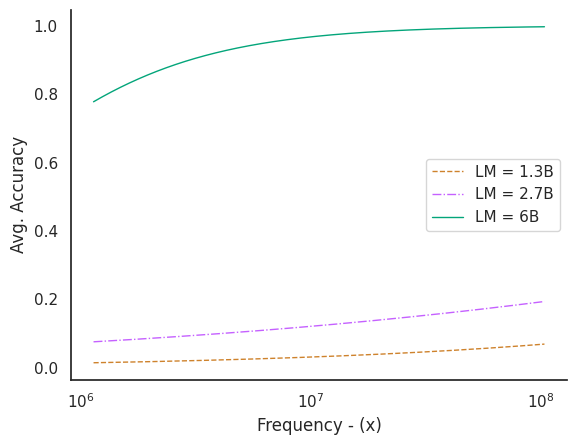

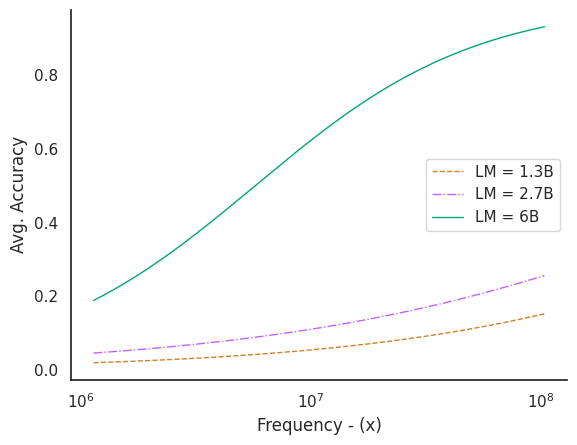

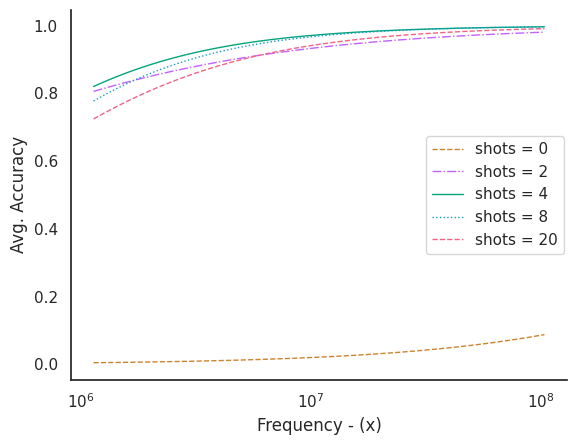

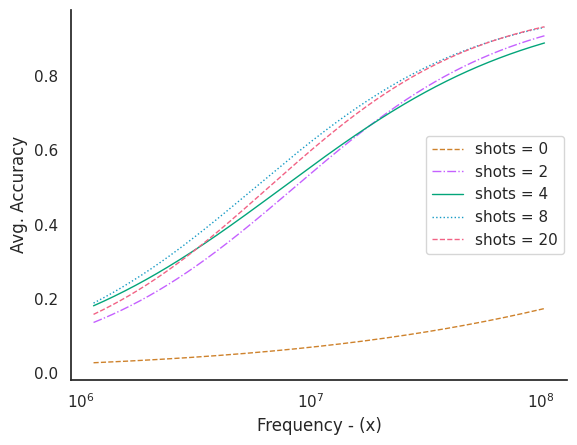

In [186]:
def draw_plots_1():
    save_logistic_regression_lines_plot_for_models('plus', ['gptjsmall', 'gptjlarge', 'gptj'], shot=8, key='x', show_plot=True)
    save_logistic_regression_lines_plot_for_models('mult', ['gptjsmall', 'gptjlarge', 'gptj'], shot=8, key='x', show_plot=True)
    save_logistic_regression_lines_plot_for_shots('plus', 'gptj', shots=[0, 2,4, 8, 20], key='x', show_plot=True)
    save_logistic_regression_lines_plot_for_shots('mult', 'gptj', shots=[0, 2,4, 8, 20], key='x', show_plot=True)
    for shot in [0, 2, 4, 8, 20]:
        save_freq_acc_plot_and_get_info('mult', shot, 'gptj', key='x', show_plot = False, quantile_number=10,
                                       plot_bar=False, plot_log_reg=False)

draw_plots_1()

Total Not Found for key xz is 235


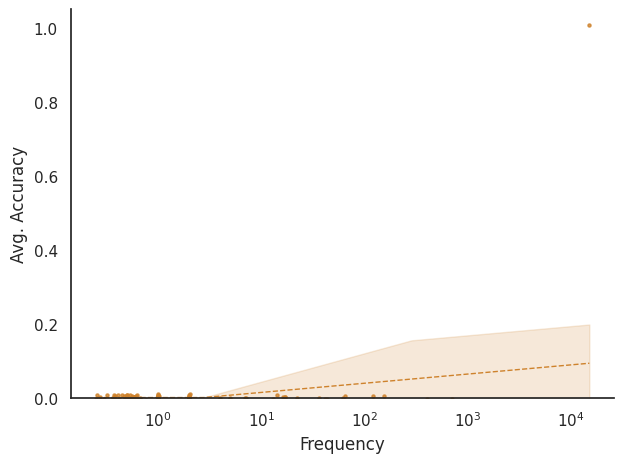

In [102]:
save_freq_acc_plot_and_get_info(
    'day', 0, 'gptj', key='x', show_plot=True, quantile_number=5, plot_bar=False, plot_log_reg=False)

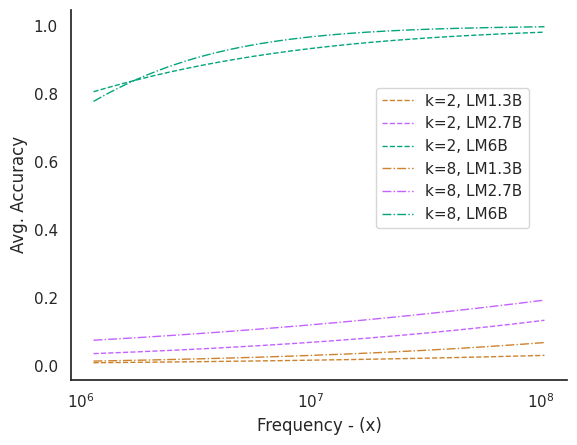

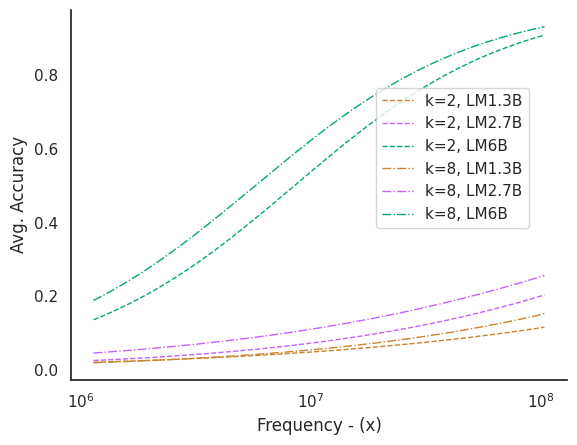

In [187]:
def draw_plots_2():
    save_logistic_regression_lines_plot_for_models_shots('plus', ['gptjsmall', 'gptjlarge', 'gptj'], shots=[2,8], key='x', show_plot=True)
    save_logistic_regression_lines_plot_for_models_shots('mult', ['gptjsmall', 'gptjlarge', 'gptj'], shots=[2,8], key='x', show_plot=True)
    # save_logistic_regression_lines_plot_for_shots('plus', 'gptj', shots=[0, 2,4, 8, 20], key='x', show_plot=True)
    # save_logistic_regression_lines_plot_for_shots('mult', 'gptj', shots=[0, 2,4, 8, 20], key='x', show_plot=True)
    # for shot in [0, 2, 4, 8, 20]:
    #     save_freq_acc_plot_and_get_info('mult', shot, 'gptj', key='x', show_plot = False, quantile_number=10)

draw_plots_2()

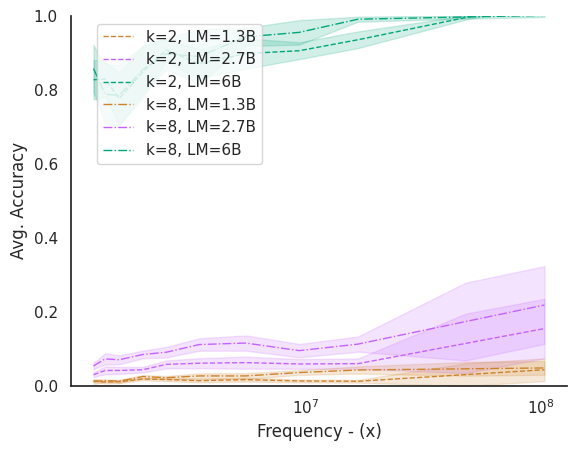

In [110]:
# plt.xlim(1e6, 5e7)
plot_utils.save_interpolation_lines_plot_for_models_shots('plus', ['gptjsmall', 'gptjlarge', 'gptj'], shots=[2, 8], key='x', show_plot=True)
# plt.xlim(1e6, 5e7)
# plt.ylim(-0.05, 1.05)
# plot_utils.save_interpolation_lines_plot_for_models_shots('decade', ['gptjsmall'], shots=[2, 16], key='x', show_plot=True)

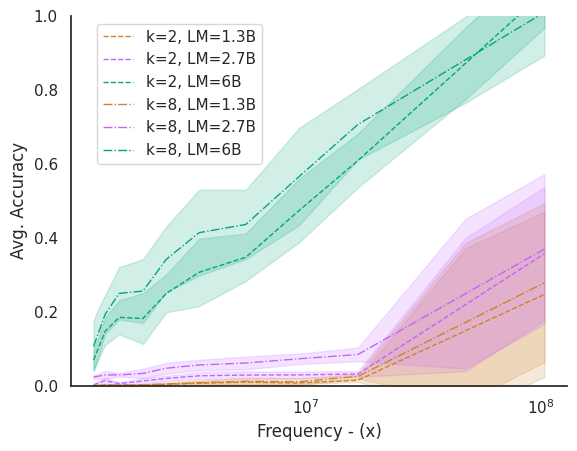

In [111]:
plot_utils.save_interpolation_lines_plot_for_models_shots('mult', ['gptjsmall', 'gptjlarge', 'gptj'], shots=[2, 8], key='x', show_plot=True)


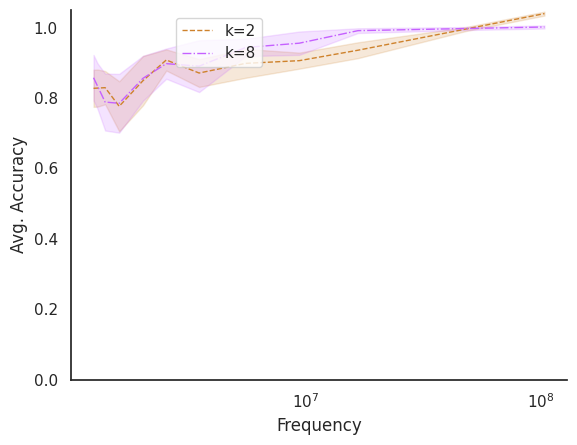

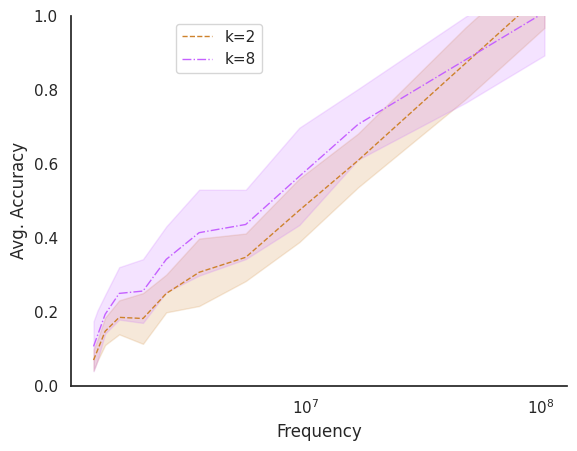

In [107]:
# plt.xlim(1e6, 5e7)
plt.ylim(0, 1.05)
plot_utils.save_interpolation_lines_plot_for_shots('plus', ['gptj'], shots=[2, 8], key='x', show_plot=True)
# plt.xlim(1e6, 5e7)
plt.ylim(0, 1)
plot_utils.save_interpolation_lines_plot_for_shots('mult', ['gptj'], shots=[2, 8], key='x', show_plot=True)

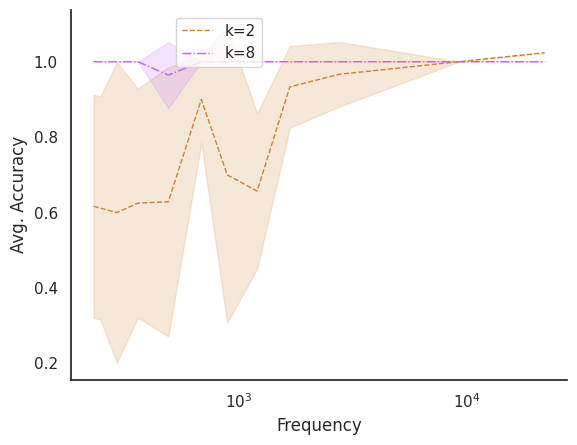

In [112]:
plot_utils.save_interpolation_lines_plot_for_shots('decade', ['gptj'], shots=[2, 8], key='x', show_plot=True)

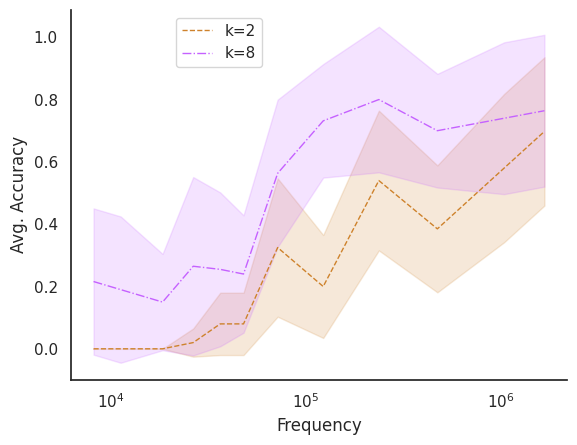

In [113]:
plot_utils.save_interpolation_lines_plot_for_shots('year', ['gptj'], shots=[2, 8], key='x', show_plot=True)

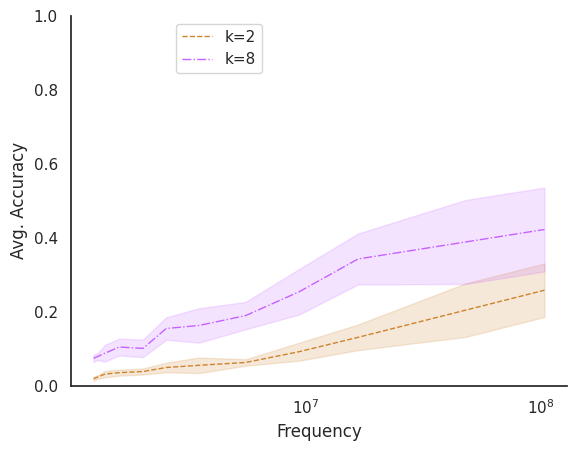

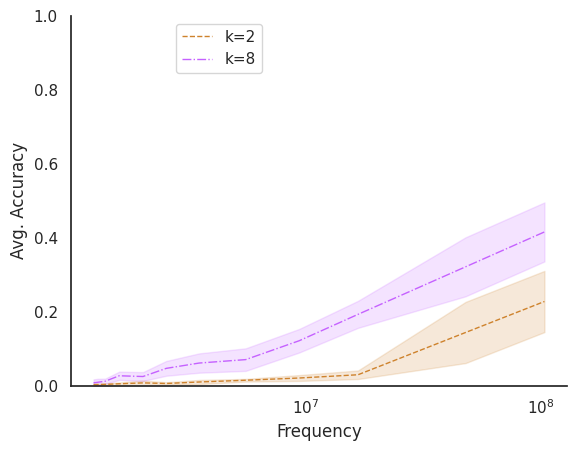

In [109]:
# plt.xlim(1e6, 5e7)
plt.ylim(0, 1.0)
plot_utils.save_interpolation_lines_plot_for_shots('plushashtag', ['gptj'], shots=[2, 8], key='x', show_plot=True)
# plt.xlim(1e6, 5e7)
plt.ylim(0, 1)
plot_utils.save_interpolation_lines_plot_for_shots('multhashtag', ['gptj'], shots=[2, 8], key='x', show_plot=True)

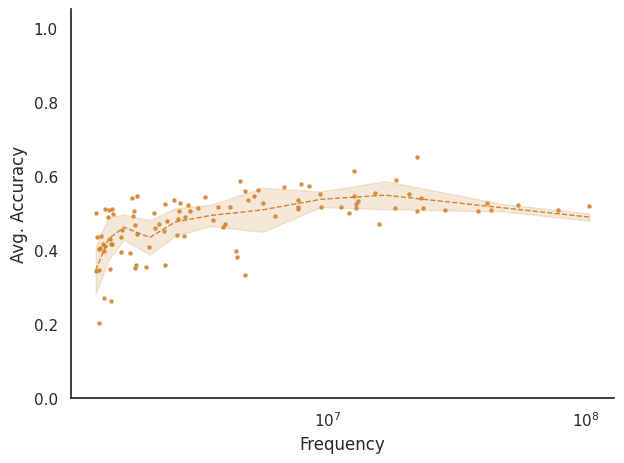

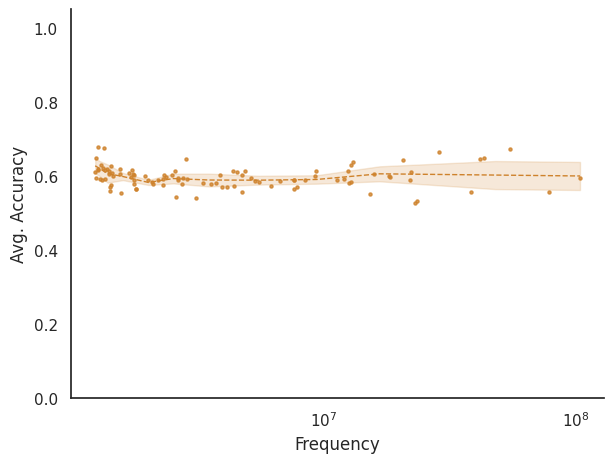

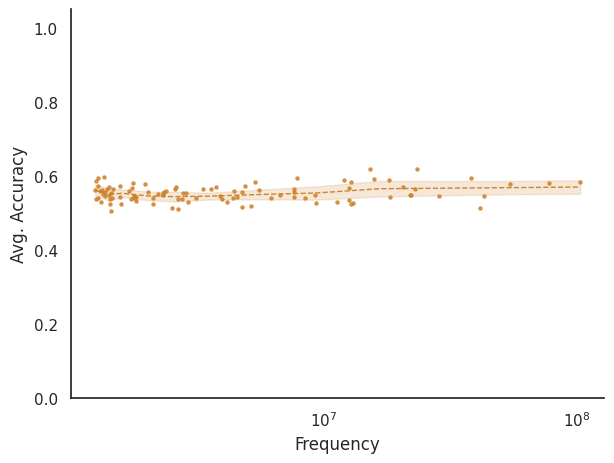

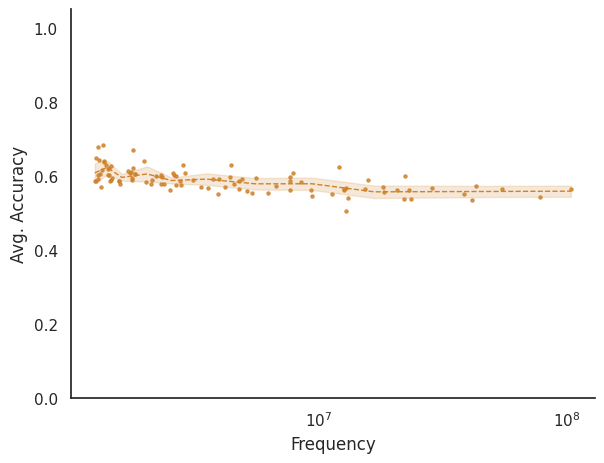

In [192]:
for shots in [0, 2, 4, 8]:
    fig, ax = plt.subplots(1, 1)
    sns.despine()
    save_freq_acc_plot_and_get_info(
        'comparemoreless', shots, 'gptj', key='x',
        show_plot=True, quantile_number=10,
        plot_log_reg=False,
        plot_bar=False)

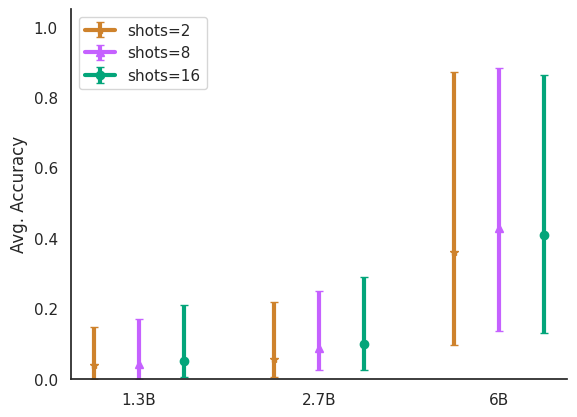

In [193]:
save_lines_plot_for_models_shots('mult', ['gptjsmall', 'gptjlarge', 'gptj'], shots=[2, 8, 16], key_type='x', show_plot=True)

[2, 1]


<ErrorbarContainer object of 3 artists>

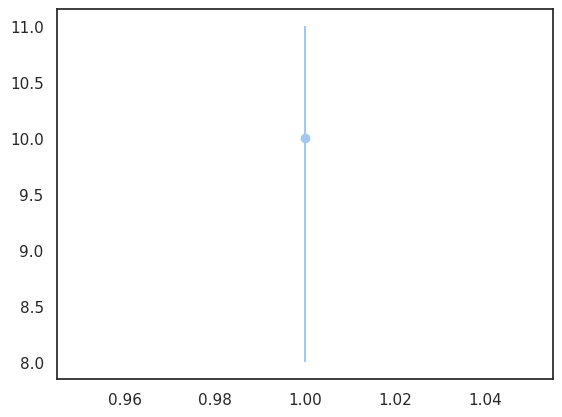

In [194]:
# x = [1, 2]
# x.shape
x = [[2,1], [3, 2], [4, 1]]

plt.errorbar( x=[1],y=[10] , yerr=[[2],[1]], marker='o')
